<a href="https://colab.research.google.com/github/ranushka-lakmal/vgg19-Tomato-leaves-disease-Predictor/blob/main/vgg19_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**VGG 19 Model**
---



Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Navigate to the directory containing your dataset

In [3]:
%cd /content/gdrive/MyDrive/tomato/leaf_data

/content/gdrive/MyDrive/tomato/leaf_data


Create train and test data generators

In [4]:
train_dir = 'train'  # Name of the folder containing training images
test_dir = 'val'  # Name of the folder containing testing images

# Define image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # VGG-19 input size
    batch_size=32,
    class_mode='categorical')

# Flow testing images in batches using the generators
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG-19 input size
    batch_size=32,
    class_mode='categorical')


Found 5026 images belonging to 5 classes.
Found 61 images belonging to 5 classes.


Load the VGG-19 model without the top layer

In [5]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 5s 0us/step


Add a custom classifier on top of the base model

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

Freeze the base model layers

In [7]:
for layer in base_model.layers:
    layer.trainable = False

Compile and train the model

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator))

158/158 [==============================] - 2885s 18s/step - loss: 0.7829 - accuracy: 0.7330 - val_loss: 0.4731 - val_accuracy: 0.8361


Save model name as model_vgg19.h5

In [9]:
model.save('/content/gdrive/MyDrive/tomato/model_vgg19.h5')

Load save model for get the confution matrix

In [10]:
from tensorflow.keras.models import load_model

saved_model_path = '/content/gdrive/MyDrive/tomato/model_vgg19.h5'
model = load_model(saved_model_path)

Make predictions on the test dataset

In [11]:
test_generator.reset()  # Reset the test generator to ensure proper order

# Predict the labels for the test dataset
y_pred = model.predict(test_generator)
y_pred_classes = tf.argmax(y_pred, axis=1)  # Convert predictions to class labels

2/2 [==============================] - 1s 188ms/step


Get the ground truth labels

In [12]:
y_true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

Calculate the confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

Visualize the confusion matrix

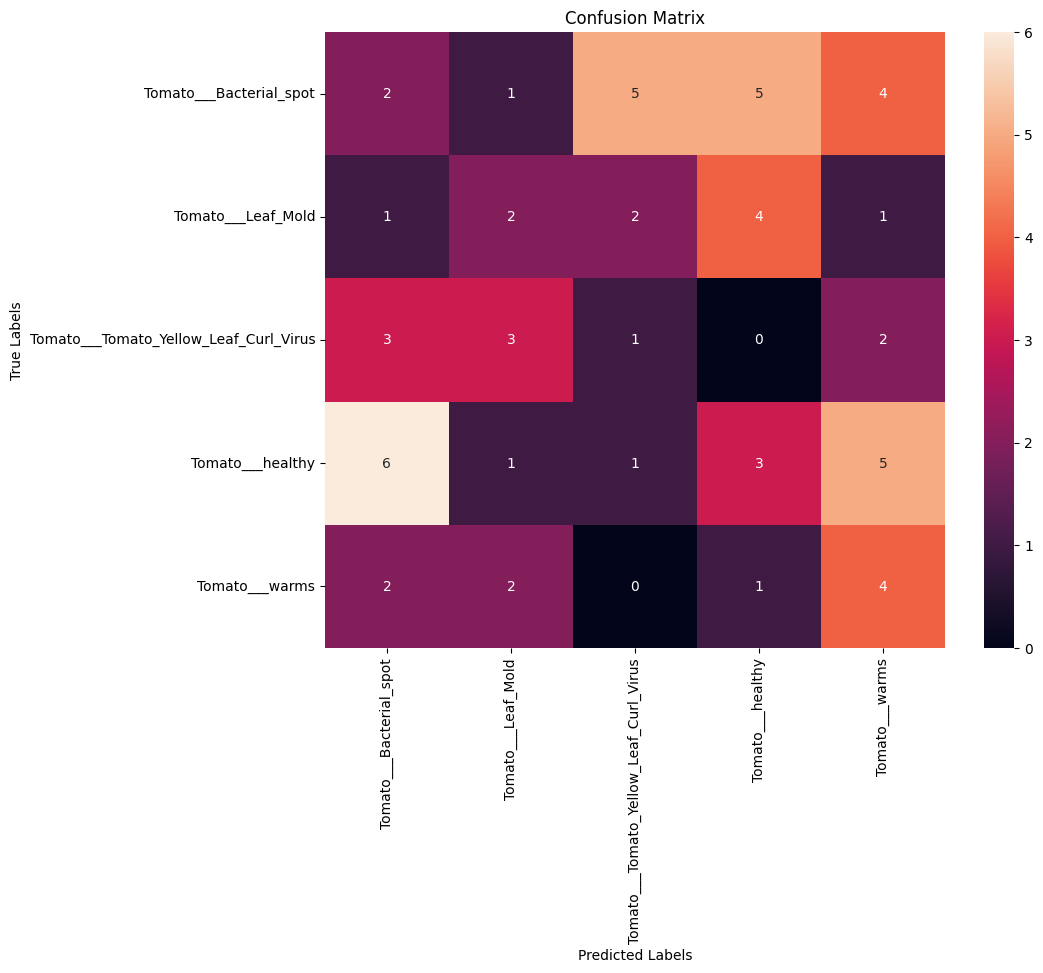

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/10
158/158 [==============================] - 29s 168ms/step - loss: 0.3229 - accuracy: 0.8963 - val_loss: 0.2911 - val_accuracy: 0.8852
Epoch 2/10
158/158 [==============================] - 27s 169ms/step - loss: 0.2307 - accuracy: 0.9218 - val_loss: 0.2092 - val_accuracy: 0.9016
Epoch 3/10
158/158 [==============================] - 28s 180ms/step - loss: 0.2234 - accuracy: 0.9270 - val_loss: 0.1772 - val_accuracy: 0.9180
Epoch 4/10
158/158 [==============================] - 26s 166ms/step - loss: 0.1610 - accuracy: 0.9475 - val_loss: 0.1934 - val_accuracy: 0.9344
Epoch 5/10
158/158 [==============================] - 27s 170ms/step - loss: 0.1405 - accuracy: 0.9546 - val_loss: 0.2130 - val_accuracy: 0.9508
Epoch 6/10
158/158 [==============================] - 27s 170ms/step - loss: 0.1453 - accuracy: 0.9538 - val_loss: 0.1401 - val_accuracy: 0.9344
Epoch 7/10
158/158 [==============================] - 27s 168ms/step - loss: 0.1353 - accuracy: 0.9528 - val_loss: 0.1923 - val_ac

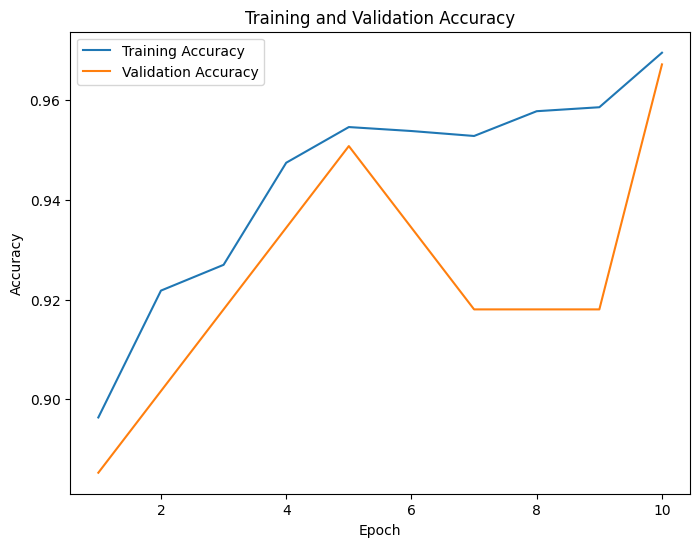

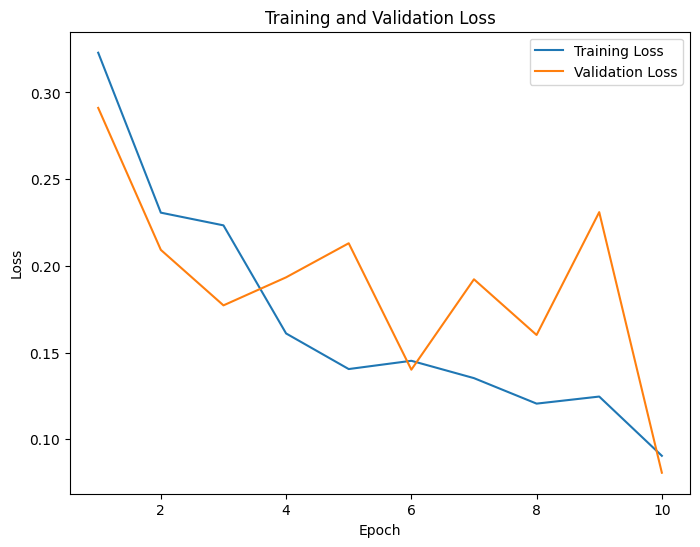

In [17]:
import matplotlib.pyplot as plt

# Train the model and save the training history
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# Get the training and validation accuracy and loss values from the history object
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
